## Step 1: Import Libraries & Load Dataset

In [25]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

data = pd.read_csv('OnlineRetail.csv', encoding="ISO-8859-1")
print("Dataset Shape:", data.shape)
print(data.head())

Dataset Shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


## Step 2: Data Cleaning & Preprocessing

In [26]:
data = data.dropna(subset=['CustomerID'])
data['CustomerID'] = data['CustomerID'].astype(int)
data = data[~data['InvoiceNo'].str.startswith('C')]
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['TotalSum'] = data['Quantity'] * data['UnitPrice']

print("Cleaned Data Shape:", data.shape)
print(data.head())

Cleaned Data Shape: (397924, 9)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSum  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom     15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom     20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom     22.00  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom     20.34  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom     20.34  


## Step 3: Compute RFM Metrics

In [29]:
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSum': 'sum'
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

print("RFM Table Shape:", rfm.shape)
print(rfm.head())

RFM Table Shape: (4339, 4)
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


## Step 4: Data Transformation, Imputation & Scaling

In [30]:
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

features = rfm[['Recency', 'Frequency', 'Monetary_log']]
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features),
                                columns=features.columns,
                                index=features.index)

scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(features_imputed)

## Step 5: K-Means Clustering Evaluation

k=2, Inertia: **13620.77**, Silhouette: **0.82**
k=3, Inertia: **8828.62**, Silhouette: **0.61**
k=4, Inertia: **6290.99**, Silhouette: **0.43**
k=5, Inertia: **4474.89**, Silhouette: **0.45**
k=6, Inertia: **3229.82**, Silhouette: **0.43**
k=7, Inertia: **2578.68**, Silhouette: **0.41**
k=8, Inertia: **2150.10**, Silhouette: **0.38**
k=9, Inertia: **1876.74**, Silhouette: **0.36**
k=10, Inertia: **1644.89**, Silhouette: **0.35**


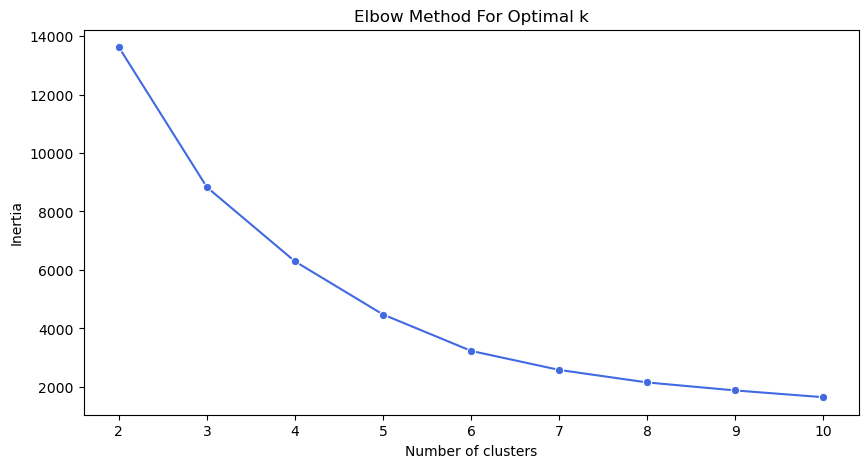

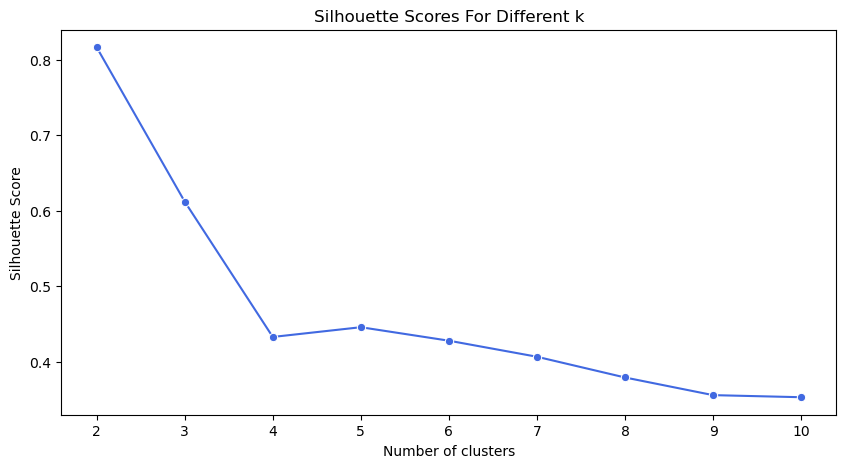

In [31]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    kmeans.fit(rfm_scaled)
    inertia_val = kmeans.inertia_
    sil_val = silhouette_score(rfm_scaled, kmeans.labels_)
    inertia.append(inertia_val)
    silhouette_scores.append(sil_val)
    print(f"k={k}, Inertia: **{inertia_val:.2f}**, Silhouette: **{sil_val:.2f}**")

plt.figure(figsize=(10,5))
sns.lineplot(x=list(K_range), y=inertia, marker='o', color="royalblue")
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x=list(K_range), y=silhouette_scores, marker='o', color="royalblue")
plt.title("Silhouette Scores For Different k")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()


## Step 6: Final K-Means Clustering with k=4

In [32]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=50)
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled)

print("Cluster Counts:")
print(rfm['Cluster'].value_counts())
final_sil = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score for k=4: **{final_sil:.2f}**")

Cluster Counts:
Cluster
0    2906
2    1142
3     283
1       8
Name: count, dtype: int64
Silhouette Score for k=4: **0.43**


## Step 7: Visualise the Clusters

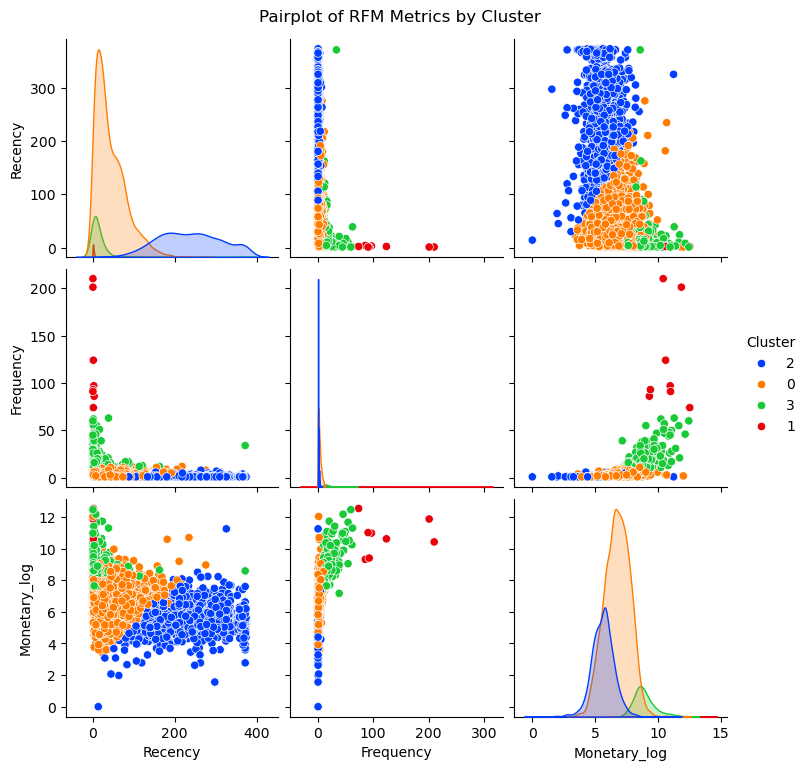

<Axes: xlabel='Cluster', ylabel='Monetary'>

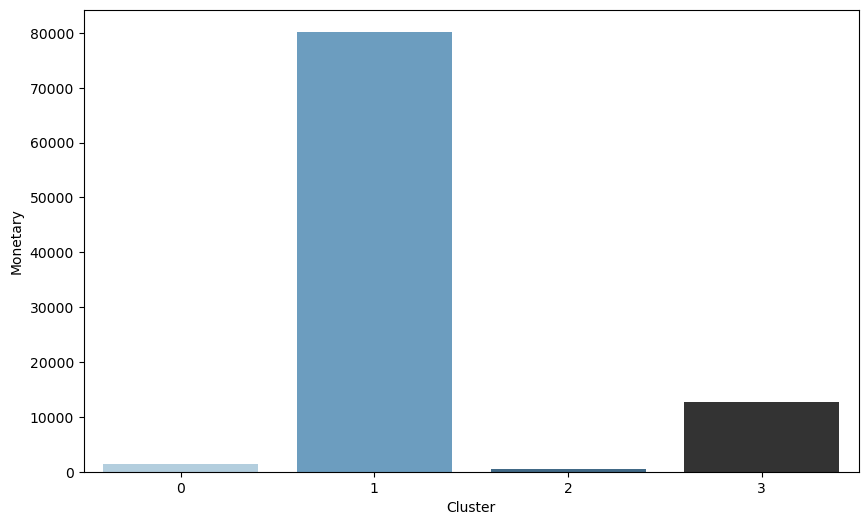

In [33]:
rfm_plot = rfm.copy()
rfm_plot['Cluster'] = rfm_plot['Cluster'].astype(str)

sns.pairplot(rfm_plot,
             vars=['Recency', 'Frequency', 'Monetary_log'],
             hue='Cluster',
             palette="bright",
             diag_kind='kde')
plt.suptitle("Pairplot of RFM Metrics by Cluster", y=1.02)
plt.show()

cluster_avg = rfm.groupby('Cluster').mean().reset_index()
cluster_avg = cluster_avg.sort_values(by='Monetary', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Cluster', 
            y='Monetary', 
            data=cluster_avg, 
            hue='Cluster', 
            palette="Blues_d", 
            dodge=False, 
            legend=False)